In [1]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt


from Calculation.geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from Calculation.material import StaticMaterial, Material, LayeredFilm, Hk2KuJ, print_Hext_parameters

from mpmath import mp
mp.dps = 1000

In [2]:
from Calculation.StationaryState import StationaryState   
        
st_state = StationaryState()

In [3]:
H1k1_hyst = 7.5e3
H1k2_hyst = 6.5e3
H2k_hyst = 12.5e3

thickness = 12e-7
Ms_hyst = 620.

#setting up film parameters
film_inst_single = LayeredFilm.from_file('default_single')
film_inst_double = LayeredFilm.from_file('default_double')

film_inst_single.update_with_Hk(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, zeroJ=True)
film_inst_double.update_with_Hk(H1k1_hyst, H1k2_hyst, H2k_hyst, Ms_hyst, zeroJ=False)


#print("single layered")
#film_inst_single.print()
#print("double layered")
#film_inst_double.print()

In [94]:
class DoubleLayerSystemEqs:
    def __init__(self):
        self.trace = pd.Series(dtype=object)
        var = pd.Series(dtype=object)
        self.var = var
        
        var['H'] = symbols("H", real=True, positive=True)
        var['Htet'], var['Hphi'] = symbols("theta_H phi_H", real=True)
        
        var['Ms'] = symbols("Ms", real=True, positive=True)
        var['Mtet'] = symbols("theta_M1 theta_M2", real=True)
        var['Mphi'] = symbols("phi_M1 phi_M2", real=True)
        var['gamma'], var['alpha'], var['t'] = symbols("gamma alpha t", real=True, positive=True)
        
        var['A'], var['Ku2'] = symbols("A K_u2", real=True, positive=True)
        var['J'] = symbols("J", real=True)
        
        var['lamb'] = symbols("lambda", complex=True)
        var['w'] = symbols("w", real=True)
        var['beta'] = symbols("beta", real=True)
        
        
        
        Ev1 = -var.Ms * var.H * (sym.sin(var.Htet) * sym.sin(var.Mtet[0]) * sym.cos(var.Hphi - var.Mphi[0]) +
                                        sym.cos(var.Htet) * sym.cos(var.Mtet[0])) + \
                                        var.A * (sym.sin(var.Mtet[0]) ** 2) + \
                                        var.Ku2 * (sym.sin(var.Mtet[0]) ** 4)
        
        Ev2 = -var.Ms * var.H * (sym.sin(var.Htet) * sym.sin(var.Mtet[1]) * sym.cos(var.Hphi - var.Mphi[1]) +
                                        sym.cos(var.Htet) * sym.cos(var.Mtet[1])) + \
                                        var.A * (sym.sin(var.Mtet[1]) ** 2) + \
                                        var.Ku2 * (sym.sin(var.Mtet[1]) ** 4)
        
        Es = var.t * Ev1 + var.t * Ev2 + \
             var.J * (sym.sin(var.Mtet[0]) * sym.sin(var.Mtet[1]) * sym.cos(var.Mphi[1] - var.Mphi[0]) +
                        sym.cos(var.Mtet[0]) * sym.cos(var.Mtet[1]))
        
        self.trace['Ev1'] = Ev1
        self.trace['Ev2'] = Ev2
        self.trace['Es'] = Es
        
        #preparing matrix
        self.sys_mat = np.zeros((4,4), dtype=sym.Add)
        
        sys_vars = [var.Mtet[0], var.Mphi[0], var.Mtet[1], var.Mphi[1]]
        diff_vars = [var.Mphi[0], var.Mtet[0], var.Mphi[1], var.Mtet[1]]
        for i in range(4):
            for j in range(4):
                self.sys_mat[i][j] = (var.gamma / var.Ms) * (1 / var.t) * Es.diff(diff_vars[i], sys_vars[j])
                if i%2==1:
                    self.sys_mat[i][j] = -self.sys_mat[i][j]
        
        for i in range(2):
            self.sys_mat[i][i] += var.lamb*sym.sin(var.Mtet[0])
            
        for i in range(2, 4):
            self.sys_mat[i][i] += var.lamb*sym.sin(var.Mtet[1])
        
        self.sys_mat[0][1] += var.alpha*var.lamb*sym.sin(var.Mtet[0])**2
        self.sys_mat[2][3] += var.alpha*var.lamb*sym.sin(var.Mtet[1])**2
        
        self.sys_mat[1][0] += -var.alpha*var.lamb
        self.sys_mat[3][2] += -var.alpha*var.lamb
        
        self.sys_mat = sym.Matrix(self.sys_mat)
        
        self.sys_mat = self.sys_mat.subs({
            var.Hphi: 0, var.Mphi[0]: 0, var.Mphi[1]: 0
        })
        self.sys_mat.simplify()
        self.trace['sys_mat'] = self.sys_mat
        
        sys_det = self.sys_mat.det(method='berkowitz')
        self.trace['sys_det'] = sys_det
        
        #group by lambda and collect pows
        sys_det_collected = sym.collect(sym.expand(sys_det), var.lamb)
        self.sys_lamb_poly_coefs = []
        for i in range(5):
            pi = sys_det_collected.coeff(var.lamb, i)
            pi = sym.factor(sym.collect(sym.expand(pi), [var.gamma, var.alpha])).subs({1+var.alpha**2: 1})
            self.sys_lamb_poly_coefs.append(pi)
        
        var.p_sym = symbols("p_0 p_1 p_2 p_3 p_4", real=True)
        
        self.w_sol_p = None
        self.w_sol_subs = None
        self.solve_w()
        
        self.b_sol_p = None
        self.b_sol_subs = None
        self.solve_beta()
        
        self.sys_sol_mult = None
        self.solve_eq()
        
    def solve_w(self):
        var = self.var
        self.w_sol_p = sym.solve(var.p_sym[4]*(var.w**4) - var.p_sym[2]*(var.w**2) + var.p_sym[0], var.w)
        
        self.w_sol_subs = self.w_sol_p.copy()
        for i in range(len(self.w_sol_subs)):
            self.w_sol_subs[i] = self.w_sol_subs[i].subs({
                var.p_sym[4]: self.sys_lamb_poly_coefs[4],
                var.p_sym[2]: self.sys_lamb_poly_coefs[2],
                var.p_sym[0]: self.sys_lamb_poly_coefs[0]
            })
        
    def solve_beta(self):
        var = self.var
        lamb_pow_im = []
        
        for i in range(0, 5):
            lamb_pow_expand = sym.expand((sym.I*var.w-var.beta)**i)
            lamb_pow_im.append(  sym.cancel(  sym.im(lamb_pow_expand)/var.w  )  )
        
        beta_eq = sym.Integer(0)
        for i in range(5):
            beta_eq+=lamb_pow_im[i]*var.p_sym[i]
        beta_eq = sym.collect(sym.expand(beta_eq), var.beta)
        self.b_sol_p = sym.solve(beta_eq, var.beta)
        self.trace['b_sol_p'] = sel.fb_sol_p
        
        self.b_sol_subs = self.b_sol_p.copy()
        for i in range(len(self.b_sol_p)):
            self.b_sol_subs[i] = self.b_sol_subs[i].subs({
                var.p_sym[4]: self.sys_lamb_poly_coefs[4],
                var.p_sym[3]: self.sys_lamb_poly_coefs[3],
                var.p_sym[2]: self.sys_lamb_poly_coefs[2],
                var.p_sym[1]: self.sys_lamb_poly_coefs[1],
                var.p_sym[0]: self.sys_lamb_poly_coefs[0]
            })
        self.trace['b_sol_subs'] = self.b_sol_subs
        
    def solve_eq(self):
        a_coefs_re = np.zeros((4,4), dtype=sym.Add)
        a_coefs_im = np.zeros((4,4), dtype=sym.Add)
        
        for i in range(4):
            for j in range(4):
                a_coefs_re[i][j] = symbols("a{}{}_r".format(i, j), real=True)
                a_coefs_im[i][j] = symbols("a{}{}_i".format(i, j), real=True)
        
        Amat = a_coefs_re + sym.I*a_coefs_im
        for i in range(4):
            for j in range(4):
                if sym.re(self.sys_mat[i, j]) == 0:
                    Amat[i][j] = sym.im(Amat[i][j])
                if sym.im(self.sys_mat[i, j]) == 0:
                    Amat[i][j] = sym.re(Amat[i][j])
        
        Amat = sym.Matrix(Amat)
        
        sys_dvar = symbols(r"\delta\theta_0 \delta\Phi_0 \delta\theta_1 \delta\Phi_1", complex=True) 
        
        #3 independent equations (4th is linear combination)
        sys_independent_eqs = [0, 0, 0]
        for i in range(3):
            for j in range(4):
                sys_independent_eqs[i] += (sys_dvar[j])*Amat[i + 1, j]
        
        sys_dvar_sol = sym.solve(sys_independent_eqs, [sys_dvar[1], sys_dvar[2], sys_dvar[3], sys_dvar[0]])
        
        self.sys_sol_mult = []
        self.sys_sol_mult.append(sym.Integer(1)) # dtet_0 - independent var
        for i in range(1, 4):
            self.sys_sol_mult.append(sym.simplify( sys_dvar_sol[sys_dvar[i]]/sys_dvar[0] ))
        
        for k in range(len(self.sys_sol_mult)):
            for i in range(4):
                for j in range(4):
                    self.sys_sol_mult[k] = self.sys_sol_mult[k].subs({
                        a_coefs_re[i][j]: sym.re(self.sys_mat[i,j]),
                        a_coefs_im[i][j]: sym.im(self.sys_mat[i,j])
                    })
            self.sys_sol_mult[k] = self.sys_sol_mult[k].subs({self.var.lamb: (sym.I*self.var.w-self.var.beta)})
            
d_sys = DoubleLayerSystemEqs()

In [95]:
d_sys.b_sol_p[0]

p_3/(4*p_4) - (9*p_3**2/(16*p_4**2) - 3*(p_2 - 2*p_4*w**2)/(2*p_4))/(3*(-27*p_3**3/(64*p_4**3) + 27*p_3*(p_2 - 2*p_4*w**2)/(16*p_4**2) + sqrt(-4*(9*p_3**2/(16*p_4**2) - 3*(p_2 - 2*p_4*w**2)/(2*p_4))**3 + (-27*p_3**3/(32*p_4**3) + 27*p_3*(p_2 - 2*p_4*w**2)/(8*p_4**2) + 27*(-p_1 + p_3*w**2)/(4*p_4))**2)/2 + 27*(-p_1 + p_3*w**2)/(8*p_4))**(1/3)) - (-27*p_3**3/(64*p_4**3) + 27*p_3*(p_2 - 2*p_4*w**2)/(16*p_4**2) + sqrt(-4*(9*p_3**2/(16*p_4**2) - 3*(p_2 - 2*p_4*w**2)/(2*p_4))**3 + (-27*p_3**3/(32*p_4**3) + 27*p_3*(p_2 - 2*p_4*w**2)/(8*p_4**2) + 27*(-p_1 + p_3*w**2)/(4*p_4))**2)/2 + 27*(-p_1 + p_3*w**2)/(8*p_4))**(1/3)/3

In [5]:
class LambdaBinding:
    def __init__(self, expr, dicts_to_subs):
        for dict_to_subs in dicts_to_subs:
            expr = expr.subs(dict_to_subs)
        self.expr = expr
        
        self.var = list(self.expr.free_symbols)
        self.func = sym.lambdify(self.var, self.expr, 'numpy')
    
    def run(self, d_var):
        args = []
        for v in self.var:
            try:
                args.append(d_var[v])
            except KeyError:
                display(d_var[v])
                raise KeyError(d_var[v])
        
        return self.func(*args)

In [6]:
def film_to_dict(film_inst):
    return {
        d_sys.var.Ms: film_inst.l1.st.Ms,
        d_sys.var.gamma: film_inst.l1.st.gamma,
        d_sys.var.alpha: film_inst.l1.st.alpha,
        d_sys.var.t: film_inst.l1.st.t,
        d_sys.var.A: film_inst.l1.st.Ku_1ord - 2*np.pi*(film_inst.l1.st.Ms**2),
        d_sys.var.Ku2: film_inst.l1.st.Ku_2ord,
        d_sys.var.J: film_inst.J
    }

In [7]:
class ExpConfig:
    def __init__(self, film_inst, Habses, Htet):
        self.film_inst = film_inst
        self.H = np.array(Habses)
        self.Htet = Htet
        
        self.max_ang = []
        self.min_ang = []
        
        for H_cur in self.H:
            Hvec = pol2cart(H_cur, self.Htet, 0.)
            
            angles = st_state.get_angles_optimize_static(
                self.film_inst,
                Hvec,
                tol=1e-8
            )
            self.max_ang.append(max( angles[0]%(2*np.pi) ,  angles[2]%(2*np.pi) ))
            self.min_ang.append(min( angles[0]%(2*np.pi) ,  angles[2]%(2*np.pi) ))
        
        self.max_ang = np.array(self.max_ang)
        self.min_ang = np.array(self.min_ang) 
        


exp_config = ExpConfig(film_inst_double, np.linspace(1e2, 6e3, 100), np.deg2rad(63.))

In [8]:
def exp_config_to_dict(config):
    return {
        d_sys.var.H: config.H,
        d_sys.var.Htet: config.Htet,
        d_sys.var.Mtet[0]: config.min_ang,
        d_sys.var.Mtet[1]: config.max_ang
    }

In [114]:
class Results:
    def __init__(self, config, film_inst):
        self.config = config
        self.film_inst = film_inst
        
        self.bind = pd.Series(dtype=object)
        
        self.bind['freq']= np.zeros(shape=(len(d_sys.w_sol_subs)), dtype=object)
        for freq_id in range(len(d_sys.w_sol_subs)):
            self.bind['freq'][freq_id] = LambdaBinding(d_sys.w_sol_subs[freq_id]/(2*sym.pi), [film_to_dict(self.film_inst)])
            
        self.bind['beta'] = np.zeros(shape=(len(d_sys.b_sol_subs)), dtype=object)
        for beta_ind in range(len(d_sys.b_sol_subs)):
            self.bind['beta'][beta_ind] = LambdaBinding(d_sys.b_sol_subs[beta_ind], [film_to_dict(self.film_inst)])
            
        self.bind['sol_mult'] = np.zeros(shape=(len(d_sys.sys_sol_mult)), dtype=object)
        for sol_ind in range(len(d_sys.sys_sol_mult)):
            self.bind['sol_mult'][sol_ind] = LambdaBinding(d_sys.sys_sol_mult[sol_ind], [film_to_dict(self.film_inst)])
        
        self.res = pd.Series(dtype=object)
        
        self.res['freq'] = []
        for i in range(len(self.bind['freq'])):
            self.res['freq'].append(self.bind['freq'][i].run(exp_config_to_dict(self.config)))
        
        self.res['beta'] = np.zeros(shape=(len(self.res.freq), len(self.bind.beta)), dtype=object)
        for freq_id in range(len(self.res.freq)):
            for beta_id in range(len(self.bind['beta'])):
                self.res['beta'][freq_id][beta_id] = self.bind['beta'][beta_id].run(
                    {**exp_config_to_dict(self.config), d_sys.var.w: 2*np.pi*self.res.freq[freq_id]+0.j}
                )
        
        self.res['sol_mult'] = np.zeros(shape=(len(self.res.freq), len(self.res.beta), len(self.bind.sol_mult)), dtype=object)
        for freq_id in range(len(self.res.freq)):
            for beta_id in range(len(self.res.beta[freq_id])):
                for sol_id in range(len(self.bind.sol_mult)):
                    self.res['sol_mult'][freq_id][beta_id][sol_id] = self.bind.sol_mult[sol_id].run(
                        {
                            **exp_config_to_dict(self.config), 
                            d_sys.var.w: 2*np.pi*self.res.freq[freq_id],
                            d_sys.var.beta: self.res.beta[freq_id][beta_id]
                        }
                    )

d_results = Results(exp_config, film_inst_double)
        

In [33]:
tau_exp_d = np.array([
    100,
    100,
    91,
    60,
    63
])

tau_num_s = np.array([
    109.8,
    84.0,
    76.6,
    71.2,
    64.9
])

tau_num_d = np.array([
    110.2,
    89.7,
    85.5,
    87.1,
    92.2
])

d_exp = pd.read_csv('data/moke/double_results_experimental.txt', sep='\t')
d_exp

,H,A1,f,df,tau_f,d_tau_f,A2,tau2,A3,tau3
0,1530,2.4,8.7,0.3,113.7,20.5,3.7,226.8,693,3044395
1,2295,4.3,9.8,0.2,115.0,16.0,5.0,202.0,3800,2947127
2,3060,5.5,11.0,0.2,114.0,16.0,8.7,349.0,-,-
3,3825,7.6,12.2,0.2,63.7,5.0,15.0,237.0,-,-
4,4590,11.0,12.9,0.1,73.6,4.0,19.8,217.0,-,-


Text(0.5, 0, 'H Oe')

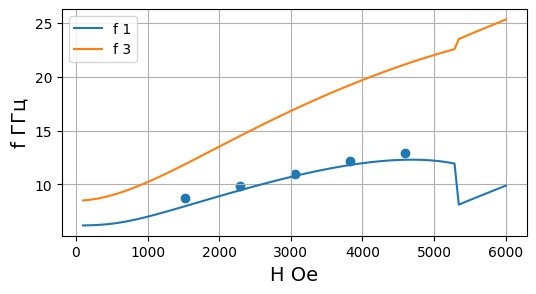

In [115]:
%matplotlib inline
plt.figure(figsize=(6, 3), dpi=100)

for freq_id in [1, 3]:
    plt.plot(d_results.config.H, d_results.res.freq[freq_id]*1e-9, label="f {}".format(freq_id))

plt.scatter(d_exp.H, d_exp.f)
    
plt.grid(True)
plt.legend()
plt.ylabel("f ГГц", fontsize=14)
plt.xlabel("H Oe", fontsize=14)

Text(0.5, 0, 'H Oe')

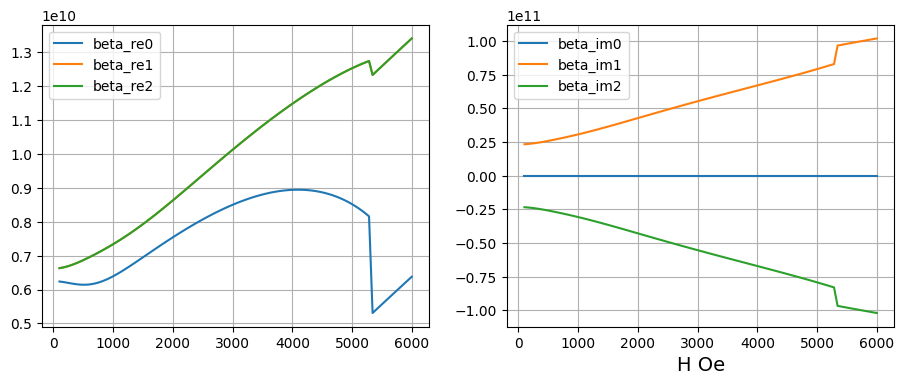

In [152]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(11, 4), dpi=100)
re_ax = axs[0]
im_ax = axs[1]

tmp_freq_id = 1
for beta_id in range(len(d_results.res.beta[tmp_freq_id])):
    re_ax.plot(d_results.config.H, np.real(d_results.res.beta[tmp_freq_id][beta_id]), label='beta_re{}'.format(beta_id))
    im_ax.plot(d_results.config.H, np.imag(d_results.res.beta[tmp_freq_id][beta_id]), label='beta_im{}'.format(beta_id))

re_ax.grid(True)
im_ax.grid(True)
re_ax.legend()
im_ax.legend()
plt.xlabel("H Oe", fontsize=14)

c:\users\sasha\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


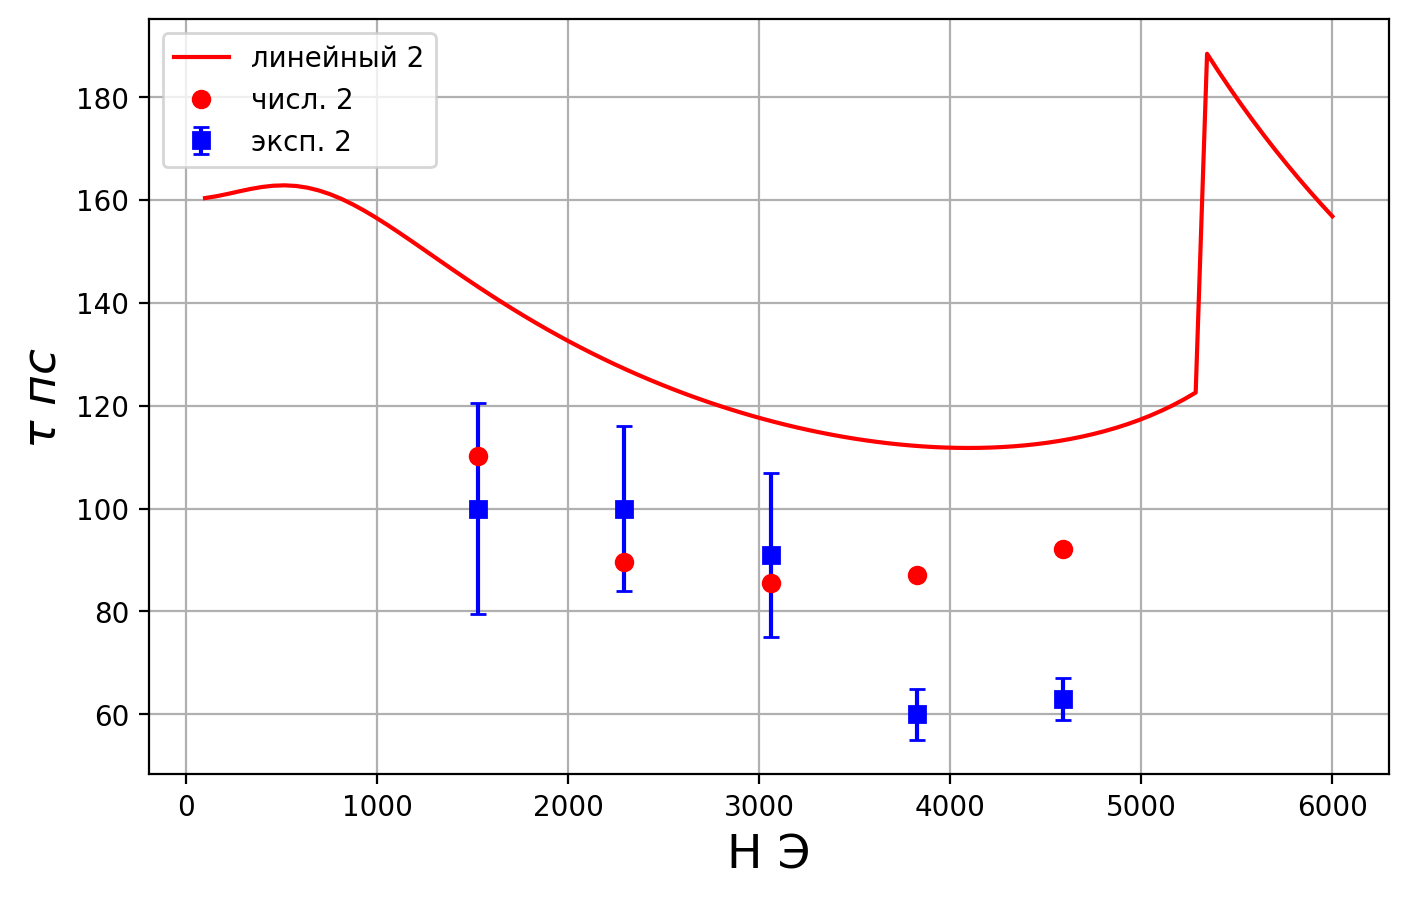

In [117]:
%matplotlib inline
plt.figure(figsize=(8, 5), dpi=200)

tmp_freq_id = 1

for beta_id in [0]:
    plt.plot(d_results.config.H, 1e12/d_results.res.beta[tmp_freq_id][beta_id], label='линейный 2', color='r')


plt.plot(d_exp.H, tau_num_d, 'ro', label='числ. 2')
#plt.errorbar(d_exp.H, d_exp.tau_f, yerr=2*dr_exp.d_tau_f,fmt='bs', label='эксп. 2')
plt.errorbar(d_exp.H, tau_exp_d, yerr=d_exp.d_tau_f, fmt='bs', label='эксп. 2',elinewidth=1.5, capsize=3)

plt.xlabel('H Э',fontsize=17)
plt.ylabel(r"$\tau\ пс$",fontsize=17)
plt.grid(True)
plt.legend()

<IPython.core.display.Javascript object>


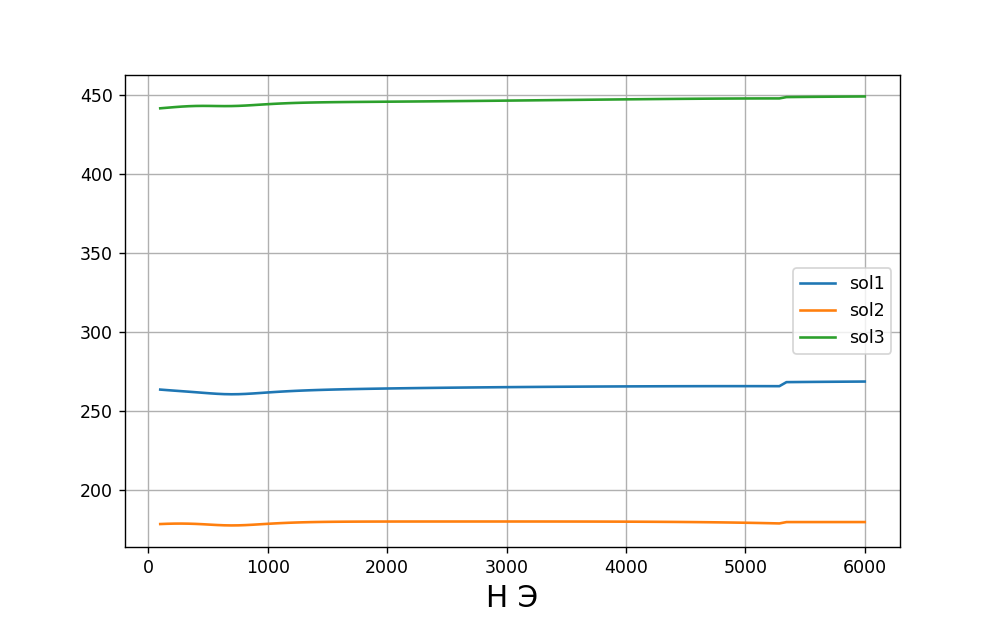

[0.00, 261.84, 178.88, 443.94]


In [154]:
%matplotlib notebook
plt.figure(figsize=(8, 5), dpi=100)

tmp_freq_id = 1
tmp_beta_id = 0

for sol_id in range(1, len(d_results.res.sol_mult[tmp_freq_id][tmp_beta_id])):
    to_plot = np.rad2deg(np.angle(d_results.res.sol_mult[tmp_freq_id][tmp_beta_id][sol_id]))
    to_plot[to_plot < 100] += 360
    plt.plot(d_results.config.H, 
             to_plot,
             label='sol{}'.format(sol_id))


plt.xlabel('H Э',fontsize=17)
#plt.ylabel(r"$\tau\ пс$",fontsize=17)
plt.grid(True)
plt.legend()

tmp_H_find = 1000.
tmp_phase_res = [0.]
for sol_id in range(1, 4):
    tmp_res = np.rad2deg(np.angle(d_results.res.sol_mult[tmp_freq_id][tmp_beta_id][sol_id]))
    tmp_res[tmp_res < 100] += 360
    ind = np.argmin(np.abs(d_results.config.H - tmp_H_find))
    tmp_phase_res.append(tmp_res[ind])
print("[{:.2f}, {:.2f}, {:.2f}, {:.2f}]".format(tmp_phase_res[0], tmp_phase_res[1], tmp_phase_res[2], tmp_phase_res[3]))

<IPython.core.display.Javascript object>


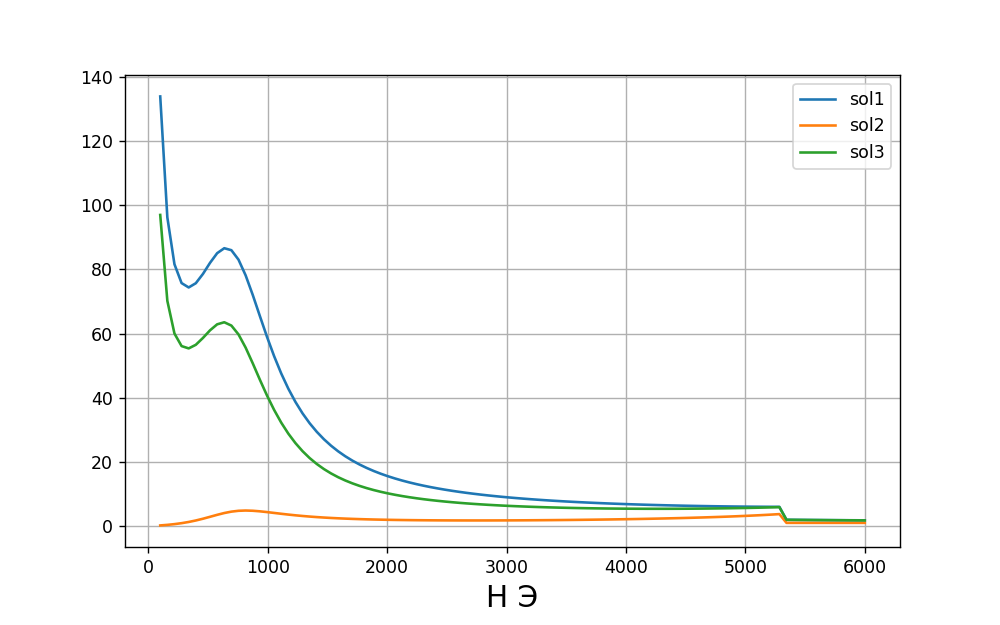

[1.00, 59.01, 4.36, 40.72]


In [156]:
%matplotlib notebook
plt.figure(figsize=(8, 5), dpi=100)

tmp_freq_id = 1
tmp_beta_id = 0

for sol_id in range(1, len(d_results.res.sol_mult[tmp_freq_id][tmp_beta_id])):
    plt.plot(d_results.config.H, 
             np.abs(d_results.res.sol_mult[tmp_freq_id][tmp_beta_id][sol_id]),
             label='sol{}'.format(sol_id))


plt.xlabel('H Э',fontsize=17)
#plt.ylabel(r"$\tau\ пс$",fontsize=17)
plt.grid(True)
plt.legend()

tmp_H_find = 1000.
tmp_mult_res = [1.]
for sol_id in range(1, 4):
    tmp_res = np.abs(d_results.res.sol_mult[tmp_freq_id][tmp_beta_id][sol_id])
    ind = np.argmin(np.abs(d_results.config.H - tmp_H_find))
    tmp_mult_res.append(tmp_res[ind])
print("[{:.2f}, {:.2f}, {:.2f}, {:.2f}]".format(tmp_mult_res[0], tmp_mult_res[1], tmp_mult_res[2], tmp_mult_res[3]))

In [ ]:
class PhaseResults:
    def __init__(self, beta_results):
        self.beta_results = beta_results
        self.freq_results = beta_results.freq_results
        self.config = beta_results.config
        self.H = self.config.H
        
        self.mult = []# freq, beta, v_mult_lamb
        
        for freq_ind in range(len(self.freq_results.freq)):
            freq_arr = self.freq_results.freq[freq_ind]
            mult_f_tmp = []
            
            for beta_ind in range(len(self.beta_results.beta[freq_ind])):
                beta_arr = self.beta_results.beta[freq_ind][beta_ind]
                mult_fb_tmp = []
                
                for mult_lamb in v_mult_lamb:
                    mult_fbm_tmp = []
                    
                    for i in range(len(self.H)):
                        H_cur = self.H[i]
                        
                        film_inst_l1 = self.config.film_inst.l1.st
                        mult_fbm_tmp.append(
                            mult_lamb(
                                H_cur, self.config.Htet,
                                film_inst_l1.Ms, self.config.min_ang[i], self.config.max_ang[i],
                                H1k1_hyst, H1k2_hyst, H2k_hyst,
                                film_inst_l1.t,
                                film_inst_l1.gamma,
                                film_inst_l1.alpha,
                                2*np.pi*freq_arr[i],
                                #1./(90e-12),
                                beta_arr[i]
                            )
                        )
                        
                    mult_fb_tmp.append(np.array(mult_fbm_tmp))
                mult_f_tmp.append(mult_fb_tmp)
            self.mult.append(mult_f_tmp)
        
        
        #self.mult_phase
        #
        #for freq_ind in range(len(self.freq_results.freq)):
        #    for beta_ind in range(len(self.beta_results.beta[freq_ind])):
        #        for mult_ind in range(len(self.mult[freq_ind][beta_ind])):
                    


phase_results = PhaseResults(beta_results_for_phase)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for freq_ind in range(len(phase_results.freq_results.freq)):
    plt.plot(phase_results.H, phase_results.freq_results.freq[freq_ind]*1e-9, label="решение {}".format(freq_ind+1))

plt.grid(True)
plt.legend(fontsize=12)
plt.ylabel("f ГГц", fontsize=14)
plt.xlabel("H Э", fontsize=14)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_freq_ind = 3 #1-our, 3-another positive
#tmp_beta_ind = 0
tmp_mult_ind = 1
for beta_ind in range(len(phase_results.mult[tmp_freq_ind])):
    phase = np.rad2deg(np.angle(phase_results.mult[tmp_freq_ind][beta_ind][tmp_mult_ind]))
    phase[phase<0.] += 360.
    plt.plot(phase_results.H, phase, label="f{}:b{}:m{}".format(tmp_freq_ind, beta_ind, tmp_mult_ind))

plt.grid(True)
plt.legend()

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_freq_ind = 3 #1-our, 3-another positive
tmp_beta_ind = 1
#tmp_mult_ind = 2
for mult_ind in range(len(phase_results.mult[tmp_freq_ind][tmp_beta_ind])):
    phase = np.rad2deg(np.angle(phase_results.mult[tmp_freq_ind][tmp_beta_ind][mult_ind]))
    phase[phase<100.] += 360.
    phase -= 360
    labels = ["$δΦ_1$", "$δθ_2$", "$δΦ_2$"]
    plt.plot(phase_results.H[phase_results.H>200], phase[phase_results.H>200],
             label=labels[mult_ind])

plt.grid(True)
plt.legend()
plt.xlabel("H Э", fontsize=14)
plt.ylabel(r"разница фаз с $δθ_1\ ^\circ$", fontsize=14)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

#tmp_freq_ind = 1 #1-our, 3-another positive
#tmp_mult_ind = 1
for beta_ind in range(len(phase_results.mult[tmp_freq_ind])):
    vi_v_abs = np.abs(phase_results.mult[tmp_freq_ind][beta_ind][tmp_mult_ind])
    plt.plot(phase_results.H, vi_v_abs, label="f{}:b{}:m{}".format(tmp_freq_ind, beta_ind, tmp_mult_ind))

plt.grid(True)
plt.legend()

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_freq_ind = 3 #1-our, 3-another positive
tmp_beta_ind = 1
#tmp_mult_ind = 2
for mult_ind in range(len(phase_results.mult[tmp_freq_ind][tmp_beta_ind])):
    vi_v_abs = np.abs(phase_results.mult[tmp_freq_ind][tmp_beta_ind][mult_ind])
    labels = ["$|δΦ_1/δθ_1|$", "$|δθ_2/δθ_1|$", "$|δΦ_2/δθ_1|$"]
    plt.plot(phase_results.H[phase_results.H>200], vi_v_abs[phase_results.H>200],
             label=labels[mult_ind])

plt.grid(True)
plt.legend()
plt.xlabel("H Э", fontsize=14)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)


#tmp_freq_ind = 3 #1-our, 3-another positive
for beta_ind in range(3):
    plt.plot(phase_results.H, np.imag(phase_results.beta_results.beta[tmp_freq_ind][beta_ind]), label="f{}:b{}".format(tmp_freq_ind, beta_ind))

    
plt.grid(True)
plt.legend()

In [ ]:
res_atan_deg_f1 = []
res_atan_deg_f3 = []

for i in range(len(results_phase.res_v1_re_f1)):
    res_atan_deg_f1_tmp = np.zeros((len(results_phase.Hax),))
    res_atan_deg_f3_tmp = np.zeros((len(results_phase.Hax),))
    
    #res_atan_deg_f1_tmp = np.rad2deg(
    #    mp.atan(
    #        np.array(np.real(results_phase.res_v1_im_f1[i])) / np.array(np.real(results_phase.res_v1_re_f1[i]))
    #    )
    #)
    #res_atan_deg_f3_tmp = np.rad2deg(
    #    np.arctan(
    #        np.array(np.real(results_phase.res_v1_im_f3[i])) / np.array(np.real(results_phase.res_v1_re_f3[i]))
    #    )
    #)
    
    for j in range(len(results_phase.Hax)):
        res_atan_deg_f1_tmp[j] = np.rad2deg(np.float64(mp.atan(
            results_phase.res_v1_im_f1[i][j].real/results_phase.res_v1_re_f1[i][j].real
        )))
        if np.real(results_phase.res_v1_re_f1[i][j]) < 0:
            res_atan_deg_f1_tmp[j]+=180.
        if res_atan_deg_f1_tmp[j] < 0.:
            res_atan_deg_f1_tmp[j] += 360.
    
    for j in range(len(results_phase.Hax)):
        res_atan_deg_f3_tmp[j] = np.rad2deg(np.float64(mp.atan(
            results_phase.res_v1_im_f3[i][j].real/results_phase.res_v1_re_f3[i][j].real
        )))
        if np.real(results_phase.res_v1_re_f3[i][j]) < 0:
            res_atan_deg_f3_tmp[j]+=180.
        if res_atan_deg_f3_tmp[j] < 0.:
            res_atan_deg_f3_tmp[j] += 360.
    
    res_atan_deg_f1.append(res_atan_deg_f1_tmp)
    res_atan_deg_f3.append(res_atan_deg_f3_tmp)
    

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

#for i in [0]:#range(len(res_atan_deg_f1)):
#    plt.plot(results_phase.Hax, res_atan_deg_f1[i], label="mod 1")
#
#for i in [1]:
#    plt.plot(results_phase.Hax, res_atan_deg_f3[i], label="mod 2")

for i in range(len(res_atan_deg_f1)):
    plt.plot(results_phase.Hax, res_atan_deg_f1[i], label="ind {}".format(i))
    
plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(0, 360)
plt.xlabel('H Э', fontsize=14)
plt.ylabel(r"$arg(\frac{δθ1}{δθ2})\ градусы$", fontsize=14)
#plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


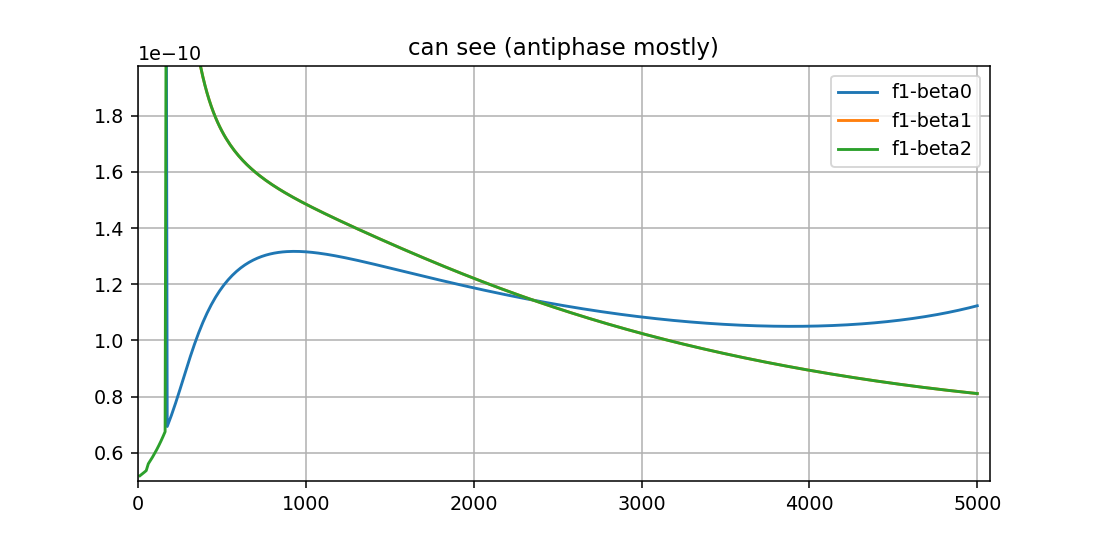

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [135]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in range(len(results_phase.res_beta_f1)):
    tmp = []
    for j in range(len(results_phase.res_beta_f1[i])): tmp.append(np.float64(results_phase.res_beta_f1[i][j].real))
    plt.plot(results_phase.Hax, 1./np.array(tmp), label="f1-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


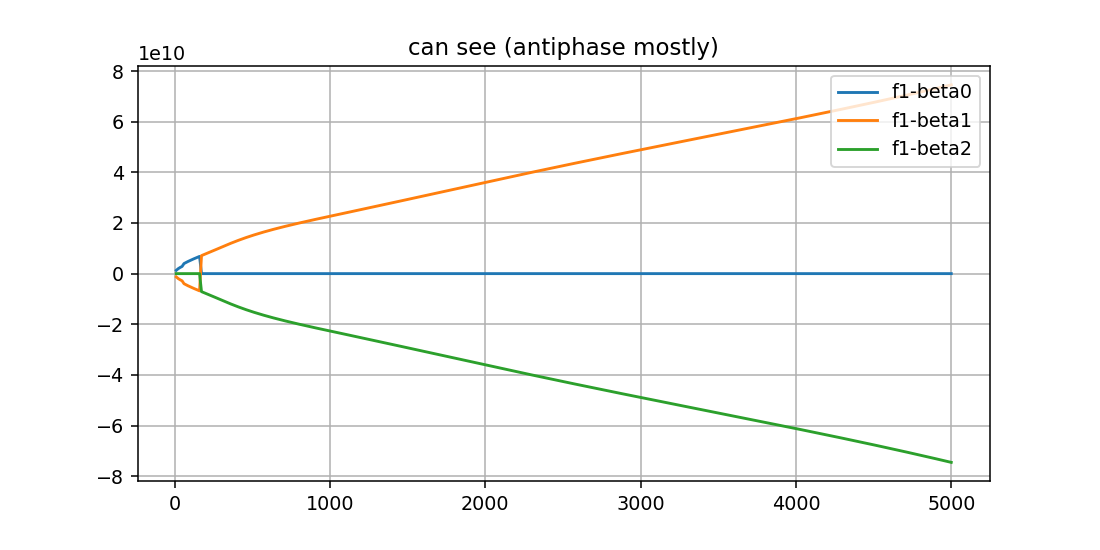

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [136]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in range(len(results_phase.res_beta_f1)):
    tmp = []
    for j in range(len(results_phase.res_beta_f1[i])): tmp.append(np.float64(results_phase.res_beta_f1[i][j].imag))
    plt.plot(results_phase.Hax, tmp, label="f1-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


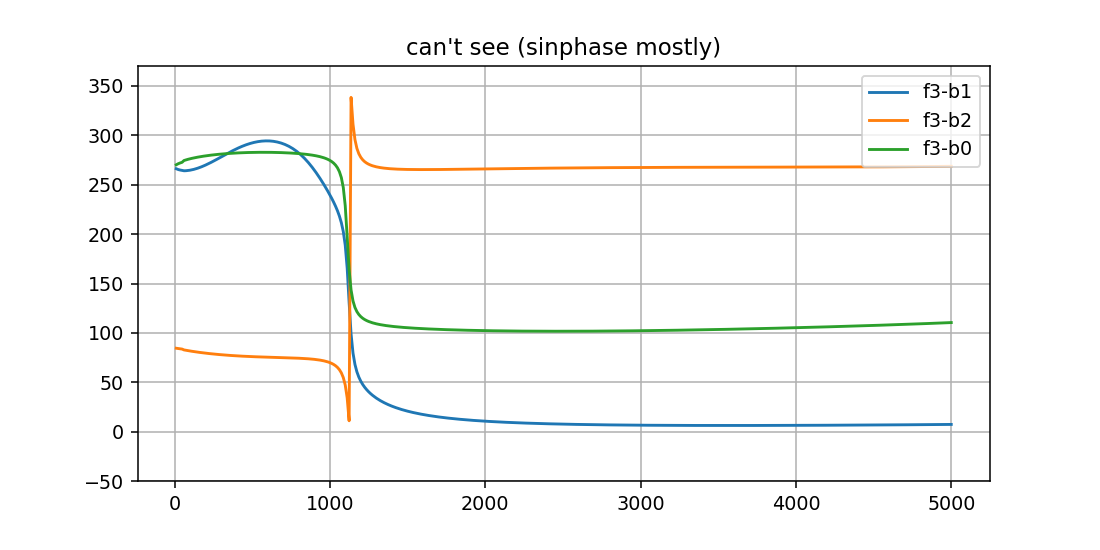

Text(0.5, 1.0, "can't see (sinphase mostly)")

In [155]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in [1,2,0]:
    plt.plot(results_phase.Hax, res_atan_deg_f3[i], label="f3-b{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(-50, 370)
plt.title("can't see (sinphase mostly)")

<IPython.core.display.Javascript object>


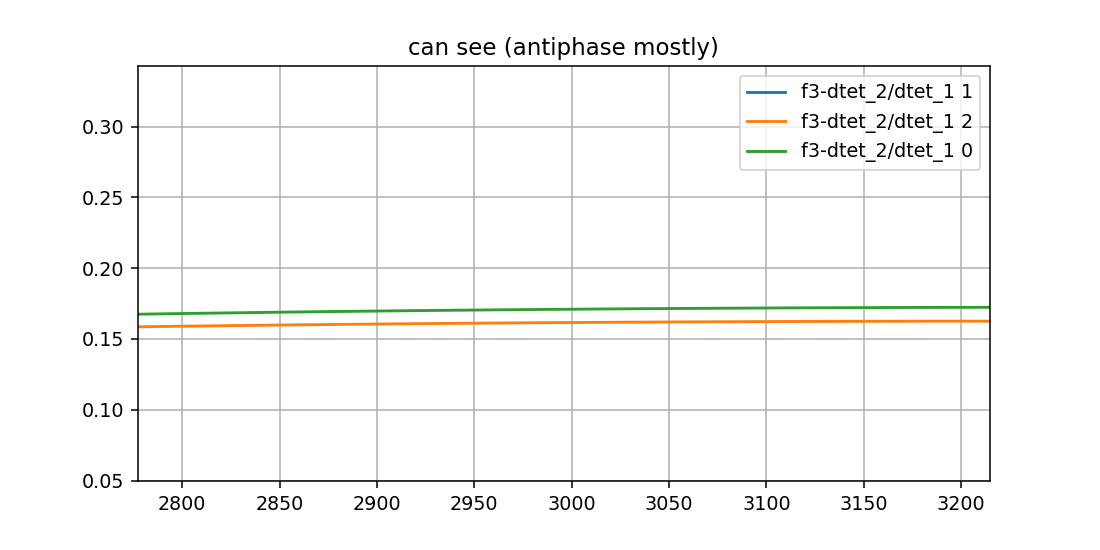

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [156]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

tmp_res = []
for i in [1,2,0]:
    tmp = np.sqrt(np.real(np.array(results_phase.res_v1_re_f3[i]))**2 + np.real(np.array(results_phase.res_v1_im_f3[i]))**2)
    if(i==1): tmp_res = tmp
    plt.plot(results_phase.Hax, tmp, label="f3-dtet_2/dtet_1 {}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

In [153]:
#tmp_res[results_phase.Hax>1999]

<IPython.core.display.Javascript object>


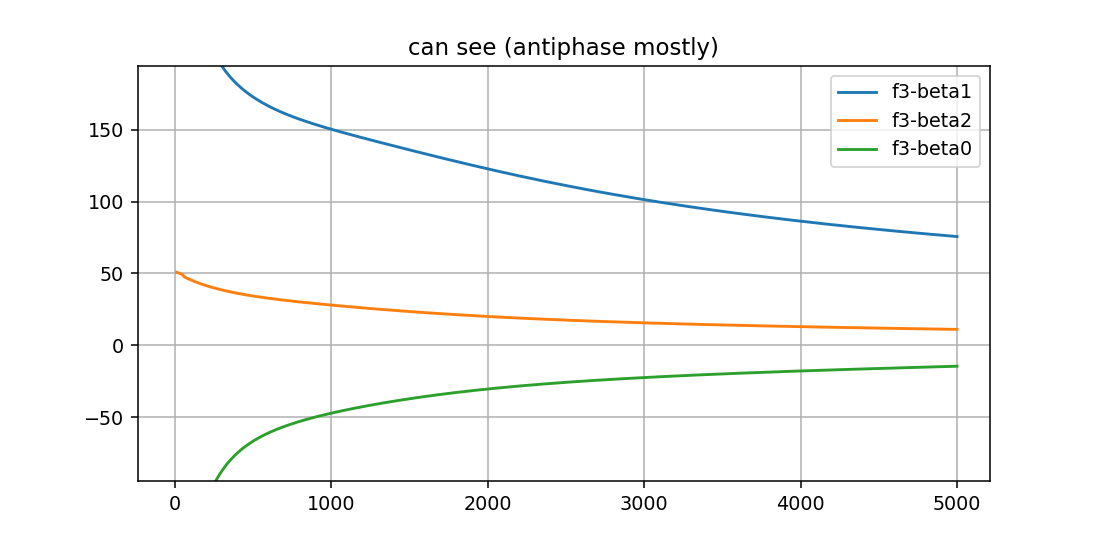

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [154]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in [1,2,0]:
    tmp = []
    for j in range(len(results_phase.res_beta_f3[i])): tmp.append(np.float64(results_phase.res_beta_f3[i][j].real))
    plt.plot(results_phase.Hax, 1./np.array(tmp)*1e12, label="f3-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

<IPython.core.display.Javascript object>


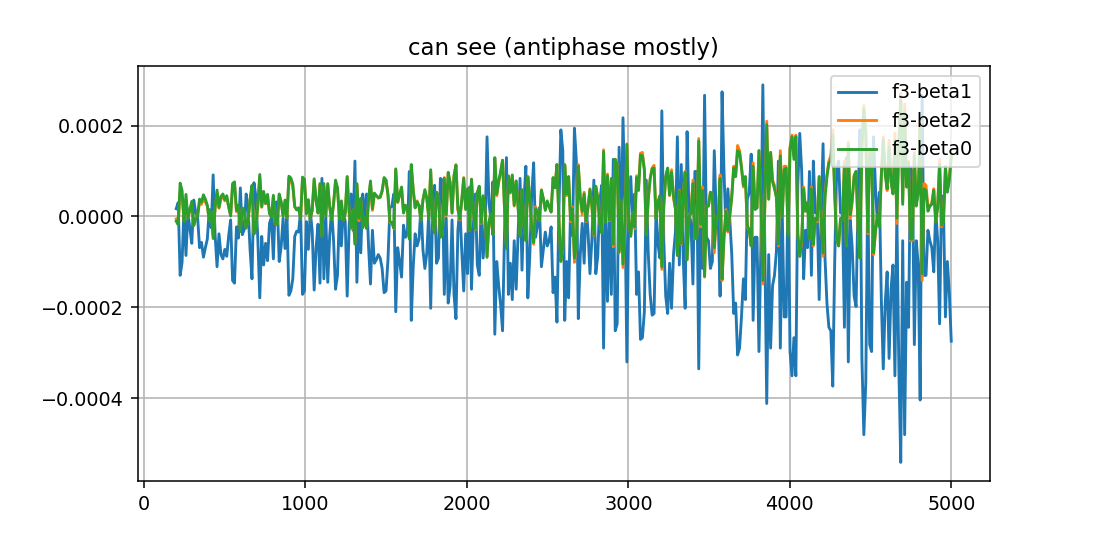

Text(0.5, 1.0, 'can see (antiphase mostly)')

In [127]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)

for i in [1,2,0]:
    tmp = []
    for j in range(len(results_phase.res_beta_f3[i])): tmp.append(np.float64(results_phase.res_beta_f3[i][j].imag))
    plt.plot(results_phase.Hax, tmp, label="f3-beta{}".format(i))

plt.grid(True)
plt.legend(loc='upper right')
#plt.ylim(-50, 370)
plt.title("can see (antiphase mostly)")

In [120]:
results_phase.res_beta_f3[2][8].imag

2.47955322265625e-05

<IPython.core.display.Javascript object>


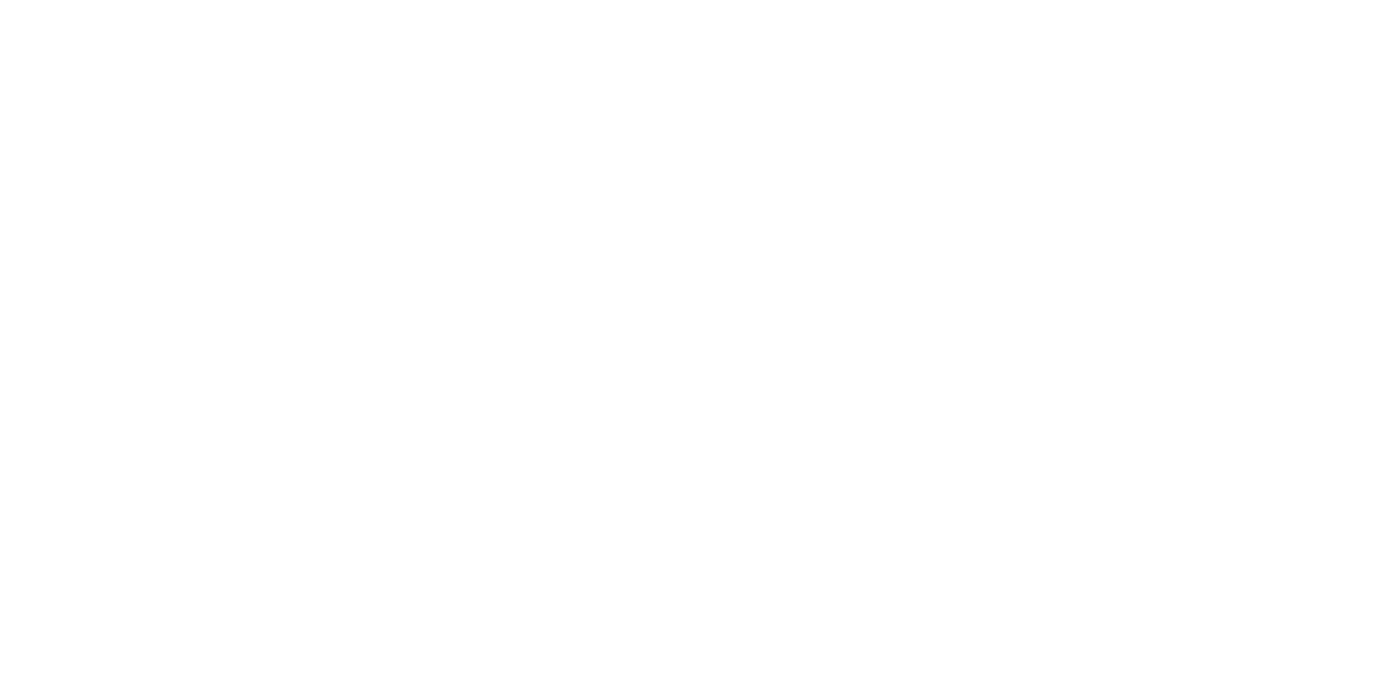

AttributeError: 'PhaseResults' object has no attribute 'res_beta'

In [121]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)
plt.plot(results_phase.Hax, np.array(results_phase.res_freq1)*1e-9, label='freq1')
plt.plot(results_phase.Hax, np.array(results_phase.res_freq3)*1e-9, label='freq3')
plt.plot(results_phase.Hax, np.array(results_phase.res_beta)*1e-9, label='beta')
plt.plot(results_phase.Hax, results_phase.res_v1_re, label='re')
plt.plot(results_phase.Hax, results_phase.res_v1_im, label='im')
plt.plot(results_phase.Hax, res_atan_deg, label='atan')
plt.plot(results_phase.Hax, results_phase.res_ang1)
plt.plot(results_phase.Hax, results_phase.res_ang2)
plt.grid(True)
plt.legend(loc='upper right')
plt.ylim(-50, 370)

In [ ]:
%matplotlib notebook
plt.figure(figsize=(8,4), dpi=110)
plt.plot(results_phase.Hax, results_phase.res_v1_im, label='im')
plt.plot(results_phase.Hax, results_phase.res_v1_re, label='re')
plt.grid(True)
plt.legend()

In [ ]:
rr_tmp = np.array(results_phase.res_beta)
np.imag(rr_tmp)/np.real(rr_tmp)

In [ ]:
results_phase.Hax